In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/Train')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
VEHICLES=10
ROADS=7

### Create dataloader

In [7]:
def convert_y(y_img):
    y_new = np.zeros(y_img.shape)
    y_new[y_img[:,:,2]==VEHICLES] = 1
    cutoff_y = int(y_new.shape[0]*.83)
    y_new[cutoff_y:,:,:] = 0
    return y_new
#     y_new[y_img[:,:,2]==ROADS] = 2
#     return y_new.astype(np.int64)

In [8]:
def open_y_image(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            im = cv2.imread(str(fn), flags)
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
#             return im
            return convert_y(im)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [9]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): 
        return open_y_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0
    def get(self, tfm, x, y):
        x,y = super().get(tfm, x, y)
#         y = (y[2,:,:]==VEHICLES).astype(np.float32)
        return x,y[0]

In [10]:
def get_data(train_path, mask_path, bs):
    x_names = np.array(glob(str(PATH/TRAIN_DN/'*.png')))
    y_names = np.array(glob(str(PATH/MASKS_DN/'*.png')))
    val_idxs = list(range(100))
    ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    aug_tfms = [
        RandomRotate(4, tfm_y=TfmType.CLASS),
        RandomFlip(tfm_y=TfmType.CLASS),
        RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)
    ]
    tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path='')
    md = ImageData(PATH, datasets, bs, num_workers=7, classes=None)
    denorm = md.trn_ds.denorm
    return md

In [11]:
def new_acc(preds, targs):
    mx,idx = torch.max(preds, 1)
    return (idx == targs).float().mean()
def dice_mult(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

## Simple upsample

In [12]:
f = resnet34
cut,lr_cut = model_meta[f]

In [13]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

## U-net (ish)

In [14]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [15]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [16]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 1, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [17]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [18]:
def get_learner(md):
    m_base = get_base()
    m = to_gpu(Unet34(m_base))
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
#     learn.crit=nn.CrossEntropyLoss()
    learn.crit = nn.BCEWithLogitsLoss()
    learn.metrics=[accuracy_thresh(0.5), dice]
    return learn

In [19]:
TRAIN_DN = 'CameraRGB-128'
MASKS_DN = 'CameraSeg-128'
sz = 128
bs = 64

In [20]:
md = get_data(TRAIN_DN, MASKS_DN, bs)

In [23]:
learn = get_learner(md)

In [26]:
x.y = next(iter(md.trn_dl))

In [24]:
learn.freeze_to(1)

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.555358   1.0765087531881463e+23 0.85252    0.025009  



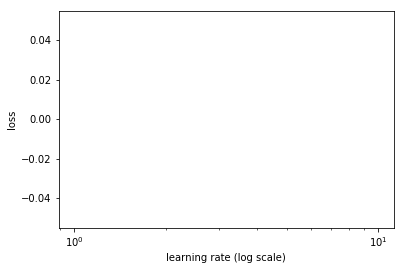

In [25]:
learn.lr_find()
learn.sched.plot()

In [30]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [31]:
learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.493687   2116.046133 0.012508   0.024634  
    1      0.226782   6.681981   0.627857   0.059438       
    2      0.1335     0.047815   0.987272   0.620291       
    3      0.088374   0.02117    0.993769   0.751993        
    4      0.062774   0.01205    0.995764   0.824149        
    5      0.046651   0.010061   0.996331   0.844966        
    6      0.03575    0.009967   0.995588   0.820054        
    7      0.028214   0.008447   0.996174   0.848144        



[array([0.00845]), 0.9961736965179443, 0.8481440054193121]

In [32]:
learn.save('128urn-car-nodash-tmp')

In [33]:
learn.load('128urn-car-nodash-tmp')

In [34]:
learn.unfreeze()
learn.bn_freeze(True)

In [35]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice             
    0      0.009057   0.009103   0.996769   0.862445  
    1      0.008956   0.007644   0.996976   0.877225         
    2      0.008693   0.007338   0.99696    0.880155         
    3      0.008469   0.007337   0.996837   0.877245         
    4      0.008321   0.007265   0.997249   0.886098         
    5      0.00823    0.007001   0.997215   0.888239         
    6      0.007947   0.00687    0.99717    0.889776         
    7      0.007772   0.006763   0.997279   0.893217         
    8      0.007596   0.006718   0.997304   0.892473         
    9      0.007529   0.00669    0.997303   0.894172         



[array([0.00669]), 0.9973028492927551, 0.894171787750808]

In [41]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice             
    0      0.007591   0.006903   0.99712    0.88868   
    1      0.007449   0.007164   0.997378   0.890749         
    2      0.007408   0.006713   0.997375   0.892547         
    3      0.007464   0.006454   0.997429   0.897542         
    4      0.007452   0.006427   0.99749    0.899941         
    5      0.007285   0.006452   0.997307   0.896357         
    6      0.007231   0.006265   0.997481   0.900199         
    7      0.007175   0.006258   0.997506   0.900578         
    8      0.007132   0.006291   0.997391   0.898963         
    9      0.006993   0.006257   0.997419   0.900385         



[array([0.00626]), 0.9974188137054444, 0.9003853382500375]

In [49]:
learn.save('128urn-car-nodash-0')

In [50]:
learn.load('128urn-car-nodash-0')

In [38]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [39]:
# py = np.argmax(py,1)

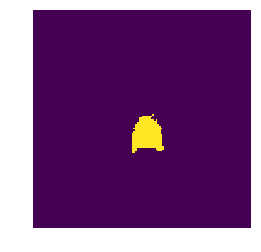

In [40]:
show_img(py[0]>0.5);

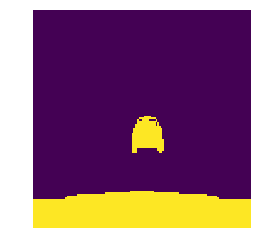

In [126]:
show_img(y[0]);

In [42]:
m.close()

NameError: name 'm' is not defined

## 256x256

In [51]:
TRAIN_DN = 'CameraRGB-256'
MASKS_DN = 'CameraSeg-256'
sz=256
bs=64

In [52]:
md = get_data(TRAIN_DN, MASKS_DN, bs)

In [53]:
lr=2e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [54]:
learn = get_learner(md)

In [55]:
learn.freeze_to(1)

In [56]:
learn.load('128urn-car-nodash-0')

In [57]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.01243    0.009937   0.996691   0.86179   
    1      0.011599   0.008166   0.996514   0.864036        
    2      0.01045    0.012736   0.996249   0.839228        
    3      0.009551   0.006707   0.997301   0.891431         
    4      0.008925   0.006571   0.997      0.884125         
    5      0.008358   0.005778   0.997455   0.902279         
    6      0.007766   0.005233   0.997748   0.914141         
    7      0.007441   0.0056     0.997502   0.905127         
    8      0.007216   0.005232   0.997733   0.913488         
    9      0.007      0.005254   0.997726   0.912003         



[array([0.00525]), 0.9977259826660156, 0.9120030169304186]

In [58]:
learn.save('256urn-car-nodash-tmp')

In [59]:
learn.unfreeze()
learn.bn_freeze(True)

In [60]:
learn.load('256urn-car-nodash-tmp')

In [61]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice             
    0      0.005358   0.004775   0.998037   0.922185  
    1      0.005389   0.004728   0.998008   0.922315         
    2      0.00546    0.004909   0.99782    0.917918         
    3      0.005418   0.004682   0.99798    0.922508         
    4      0.005274   0.004607   0.998078   0.925024         
    5      0.005184   0.00456    0.998084   0.925869         
    6      0.00518    0.004555   0.998113   0.926261         
    7      0.00519    0.004534   0.998112   0.926414         



[array([0.00453]), 0.9981123423576355, 0.9264143660827088]

In [62]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice             
    0      0.005107   0.004599   0.998221   0.925723  
    1      0.005003   0.004813   0.997827   0.918865         
    2      0.005039   0.004496   0.998158   0.926653         
    3      0.004947   0.004397   0.998181   0.928381         
    4      0.004972   0.004507   0.998052   0.925244         
    5      0.004921   0.004358   0.998148   0.928538         
    6      0.004887   0.004434   0.998155   0.927189         
    7      0.004853   0.004397   0.998154   0.927689         



[array([0.0044]), 0.9981543040275573, 0.9276888659961057]

In [63]:
learn.save('256urn-car-nodash')

In [64]:
learn.load('256urn-car-nodash')

In [65]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [66]:
py = np.argmax(py,1)

TypeError: Invalid dimensions for image data

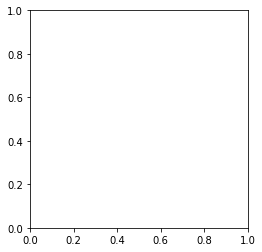

In [67]:
show_img(py[0]);

In [ ]:
show_img(y[0]);

In [ ]:
m.close()

## 512x512

In [19]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
sz=608
bs=8

In [20]:
md = get_data(TRAIN_DN, MASKS_DN, bs)

In [21]:
learn = get_learner(md)

In [22]:
learn.load('256urn-car-nodash')

In [23]:
learn.freeze_to(1)

In [24]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [77]:
learn.fit(lr,1, wds=wd, cycle_len=2,use_clr=(5,4))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.011298   0.008864   0.996412   0.848884  
    1      0.007805   0.007125   0.99707    0.883004         



[array([0.00713]), 0.9970695519447327, 0.8830044567184561]

In [78]:
learn.save('600urn-car-nodash-tmp')

In [25]:
learn.load('600urn-car-nodash-tmp')

In [26]:
learn.unfreeze()
learn.bn_freeze(True)

In [27]:
lrs = np.array([lr/200,lr/30,lr])

In [28]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice               
    0      0.005526   0.004658   0.998136   0.919265  
    1      0.005033   0.004299   0.998175   0.922722           
    2      0.004607   0.004195   0.998155   0.922677           
    3      0.004518   0.004143   0.998191   0.924341           



[array([0.00414]), 0.9981907343864441, 0.9243407917872863]

In [29]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice               
    0      0.00509    0.009801   0.996661   0.861483  
    1      0.004455   0.004035   0.998177   0.924482           
    2      0.00437    0.003944   0.998258   0.927507           
    3      0.004255   0.003888   0.998285   0.928733           



[array([0.00389]), 0.9982854127883911, 0.9287334797767385]

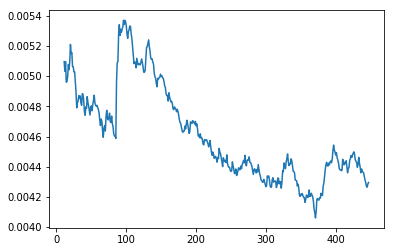

In [30]:
learn.sched.plot_loss()

In [31]:
learn.save('600urn-car-nodash')

In [26]:
learn.load('600urn-car-nodash')

In [27]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

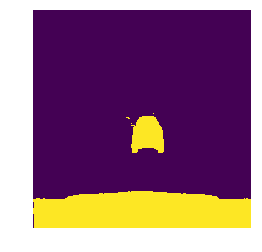

In [28]:
show_img(py[0]>0);

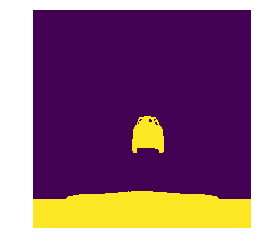

In [29]:
show_img(y[0]);

## Save results

In [32]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO

In [33]:
m_base = get_base()
m = to_gpu(Unet34(m_base))

In [34]:
# model_summary(m, [3,608,800])

In [35]:
# learn.load('1024urn')
load_model(m, str(PATH/'models/600urn-car-nodash.h5'))

In [36]:
# file = sys.argv[-1]
file = 'test_video.mp4'

if file == 'demo.py':
    print("Error loading video")
    quit

# Define encoder function
def encode(array):
    pil_img = Image.fromarray(array)
    buff = BytesIO()
    pil_img.save(buff, format="PNG")
    return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)

In [37]:
# resized_video = np.array([scipy.misc.imresize(f, size=(512,512)) for f in video])

In [38]:
def normalize(x):
    if np.mean(x) > 1:
        x = x/255
    m,s = imagenet_stats
    x = (x-m)/s
    return x
def preprocess(video):
    f1_norm = normalize(video)
    f1_roll = np.rollaxis(f1_norm, 3, 1)
    f1_pad = np.pad(f1_roll, [(0,0),(0,0),(0,8),(0,0)], mode='constant')
    return f1_pad

In [39]:
f1 = preprocess(video)

In [40]:
results = []
for i in range(0,f1.shape[0],8):
    xv = VV(torch.from_numpy(f1[i:i+8]).contiguous().float())
    preds = m(xv)
#     mx,idx = torch.max(preds, 1)
    preds = preds[:,:-8,:]
    i = preds.exp()
    i = (i>0.5).long()
#     preds_bin = preds > 0.5
    results.append(i)

In [41]:
r_stacked = torch.cat(results,0)
r_np = r_stacked.data.cpu().numpy()

In [42]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(video[index])
    ax2.imshow(r_np[index])

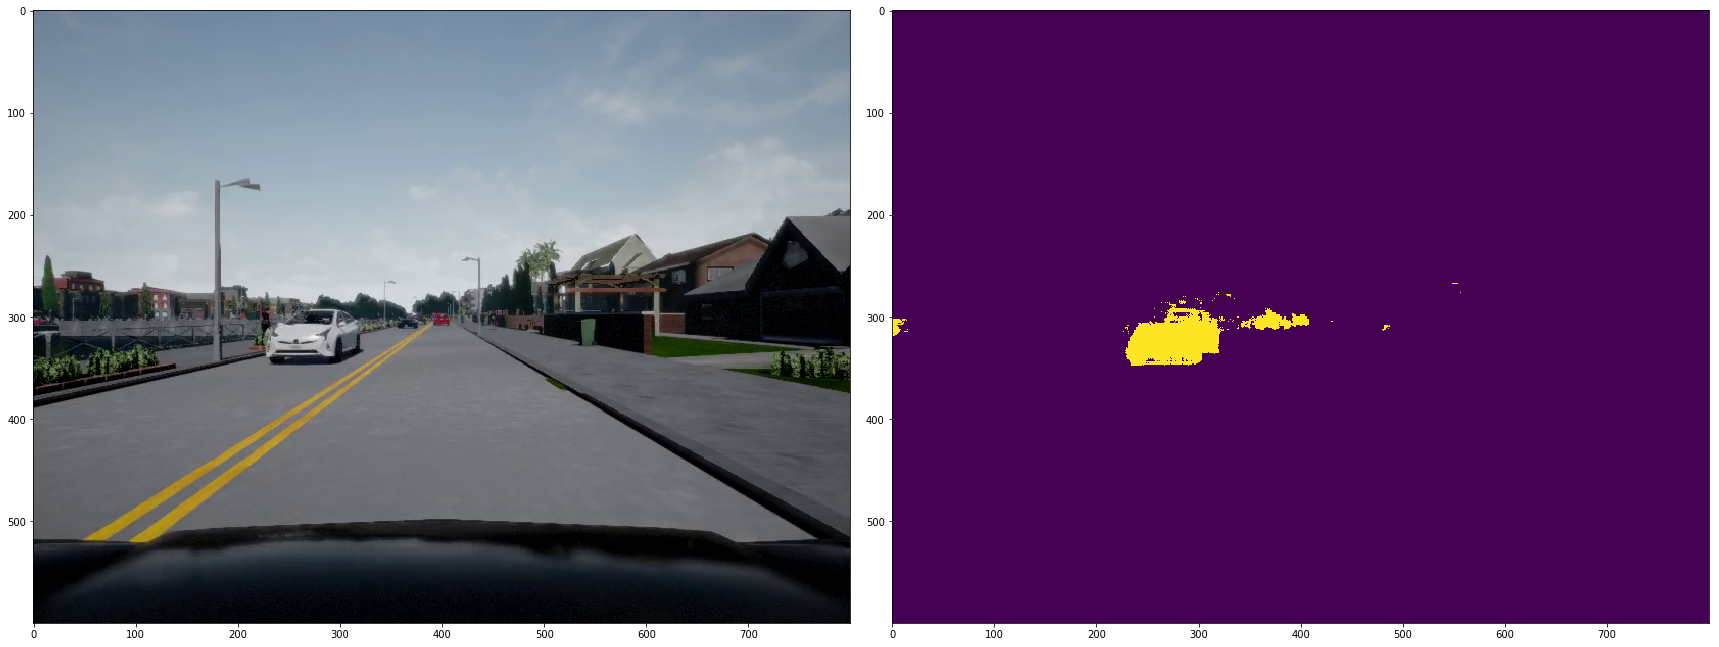

In [43]:
plot_res(10)

In [44]:
answer_key = {}

# Frame numbering starts at 1
frame_idx = 1
for frame in r_np:
    # Look for red cars :)
    binary_car_result = (frame==1).astype('uint8')
#     print(np.mean(binary_car_result))
    
    # Look for road :)
    binary_road_result = (frame==0).astype('uint8')

    answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
    
    # Increment frame
    frame_idx+=1

# Print output in proper json format
tester_data = json.dumps(answer_key)
with open('tester_data_car_only', 'w') as f:
    f.write(tester_data)
print(json.dumps(answer_key))

{"1": ["iVBORw0KGgoAAAANSUhEUgAAAyAAAAJYCAAAAAC/Hd2sAAAMkElEQVR4nO3dV5KrOBQAUOnV7H/Lmg+yCCa5wdI5r2Y6GIcGLleZEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACA2sUQs+/j+sb7/bvjReB5Mf8+3fGq/93xIvC8FENMMYQUb4qNEMJNaQieNpzI9wVHCIpY/L44rn+ke+NDBqEA3Vl8c3CMXxp+Q5xGwfQEvj9CBAg/rT2B762Zz18ffkMMk0jo4uNr76eSzs8ZXdVTCPdXzFfeC15vaK168lPAi7moAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCC+PQHYJVj87y4dBAcmAL99/QH+DExhdCEQkwxhBDS+JE2RFK7VYqjx7dfNe7a7nZdTD/z7r9AgOzXncQxhRBiljDGP2ep5NPJH9Nj56fA+OTf0x/gleJiEerz07IfNl4kjjcfvZ1i2ssIkCWLF9bhnP58FsdPW6Xx4yn0OcQl/WUEyFxeemqlSWEpded0bHx8zaWfYohZfV8GeRkBMhPT+nV8cv6m2W+WtlyInSbOUgopZDV9GeRtBMhMiqEr8sT2X8iv9G0r1d7TuX2FybMXvv8Dy/F8ss5VAwGyZbjGhxAmNZDU/rfzBI/Nay2/x19a+wwy1wpXjkycnCujn/LSVRsnaztwdsbFFFPed9L8Pt/uyMc9reu2aZqsG6JkToDslBew+j7Ble3XqzFLj/x9P2EXran5XnCsECB7jfbUuHa+FiFp

### Decoding car

In [46]:
PATH

PosixPath('../data/Train')

In [51]:
from scipy import misc
def decode(packet):
	img = base64.b64decode(packet)
	filename = PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open('results.json') as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

In [52]:
def plot_ans(index):
    ans = decode(ans_data[str(index)][0])
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(r_np[index])
    ax1.set_title('Mine', fontsize=35)
    ax2.imshow(ans)
    ax2.set_title('Answer', fontsize=35)
    ax3.imshow(video[index])
    ax2.set_title('Original', fontsize=35)

/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


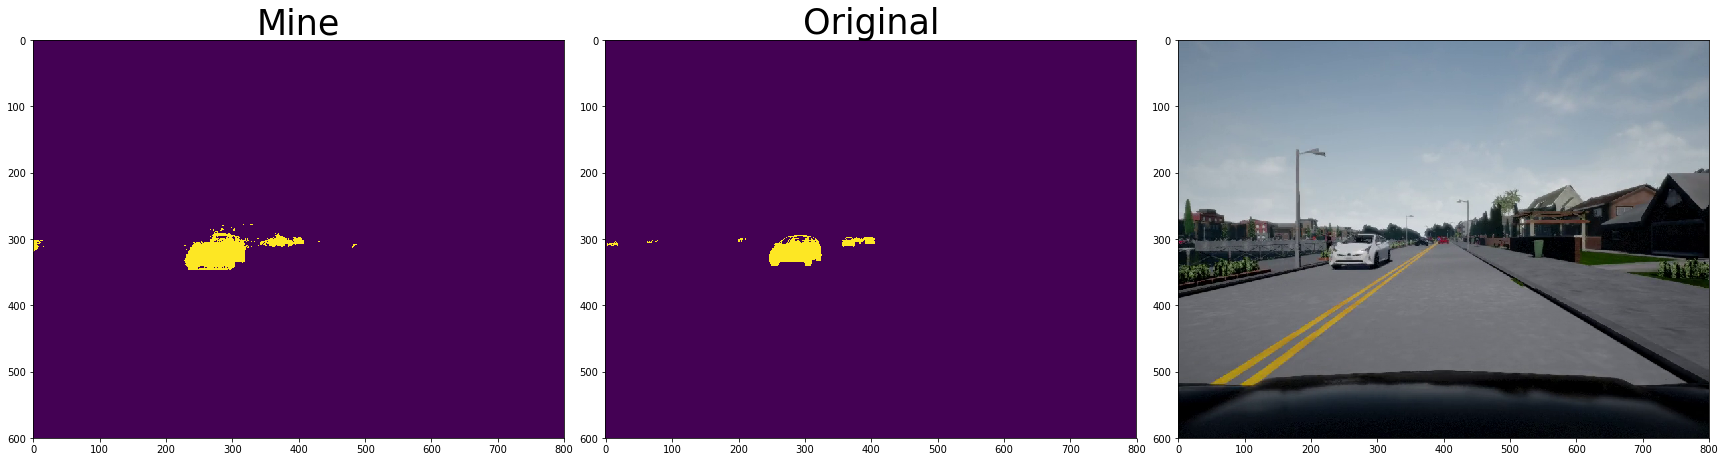

In [56]:
plot_ans(10)

In [49]:
ans = decode(ans_data['1'][0])

NameError: name 'misc' is not defined

In [50]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()